# Heart Disease Prediction
#### - The goal of this project is to create a deep learning network that predicts weather or not a patient will have heart disease based on some clinical features.
#### - This project was designed by Mike X Cohen for his Deep Understanding of Deep Learning Course.
#### - This is my unique solution to this project. Much of the code for this project has been adapted from this course.


## Data Cleaning and Preprocessing

In [254]:
### import libraries

# for DL modeling
import torch
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import copy

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# for data
from ucimlrepo import fetch_ucirepo 

In [390]:

# fetch dataset 
# https://archive.ics.uci.edu/dataset/45/heart+disease this is the link to the dataset I used
# I followed the instructions on the webpage for the data set for importing it to python
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  


In [256]:
print(X.head()) #X contains all of the clinical features we will use to predict our target features
print(y.head()) #y contains information regarding the presence of heart disease in each patient. 0 Indicates no presence, and numbers 1-4 indicate heart disease of increasing severities.

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0  
   num
0    0
1    2
2    1
3    0
4    0


In [257]:
missing_values = X.isna()
print(missing_values.sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64


In [258]:
# Replace the missing values with the mode

# find the mode
thal_mode = X["thal"].mode().iloc[0]
ca_mode = X["ca"].mode().iloc[0]

# replace missing ca
missing_ca_indices = X['ca'].isnull()
X.loc[missing_ca_indices, "ca"] = ca_mode

#replace missing thal
missing_thal_indices = X['thal'].isnull()
X.loc[missing_thal_indices, "thal"] = thal_mode


missing_values = X.isna()
print(missing_values.sum())




age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


#### I'm first going to binarize y to contain only information on whether or not the patient has heart disease. I will try to predict this value.


In [259]:
y_norm1 = pd.DataFrame(index = range(303)) #initialize new DF to have same length as original
y_norm1["num"] = None
for idx, val in enumerate(y["num"]):
    if val>0:
        y_norm1.at[idx, "num"]=1
    else:
        y_norm1.at[idx,"num"]=0


### Let's Get Exploratory

In [260]:
X.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,4.722772
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,1.938383
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


In [261]:
for i in X.keys():
  print(f'{i} has {len(np.unique(X[i]))} unique values')

age has 41 unique values
sex has 2 unique values
cp has 4 unique values
trestbps has 50 unique values
chol has 152 unique values
fbs has 2 unique values
restecg has 3 unique values
thalach has 91 unique values
exang has 2 unique values
oldpeak has 40 unique values
slope has 3 unique values
ca has 4 unique values
thal has 3 unique values


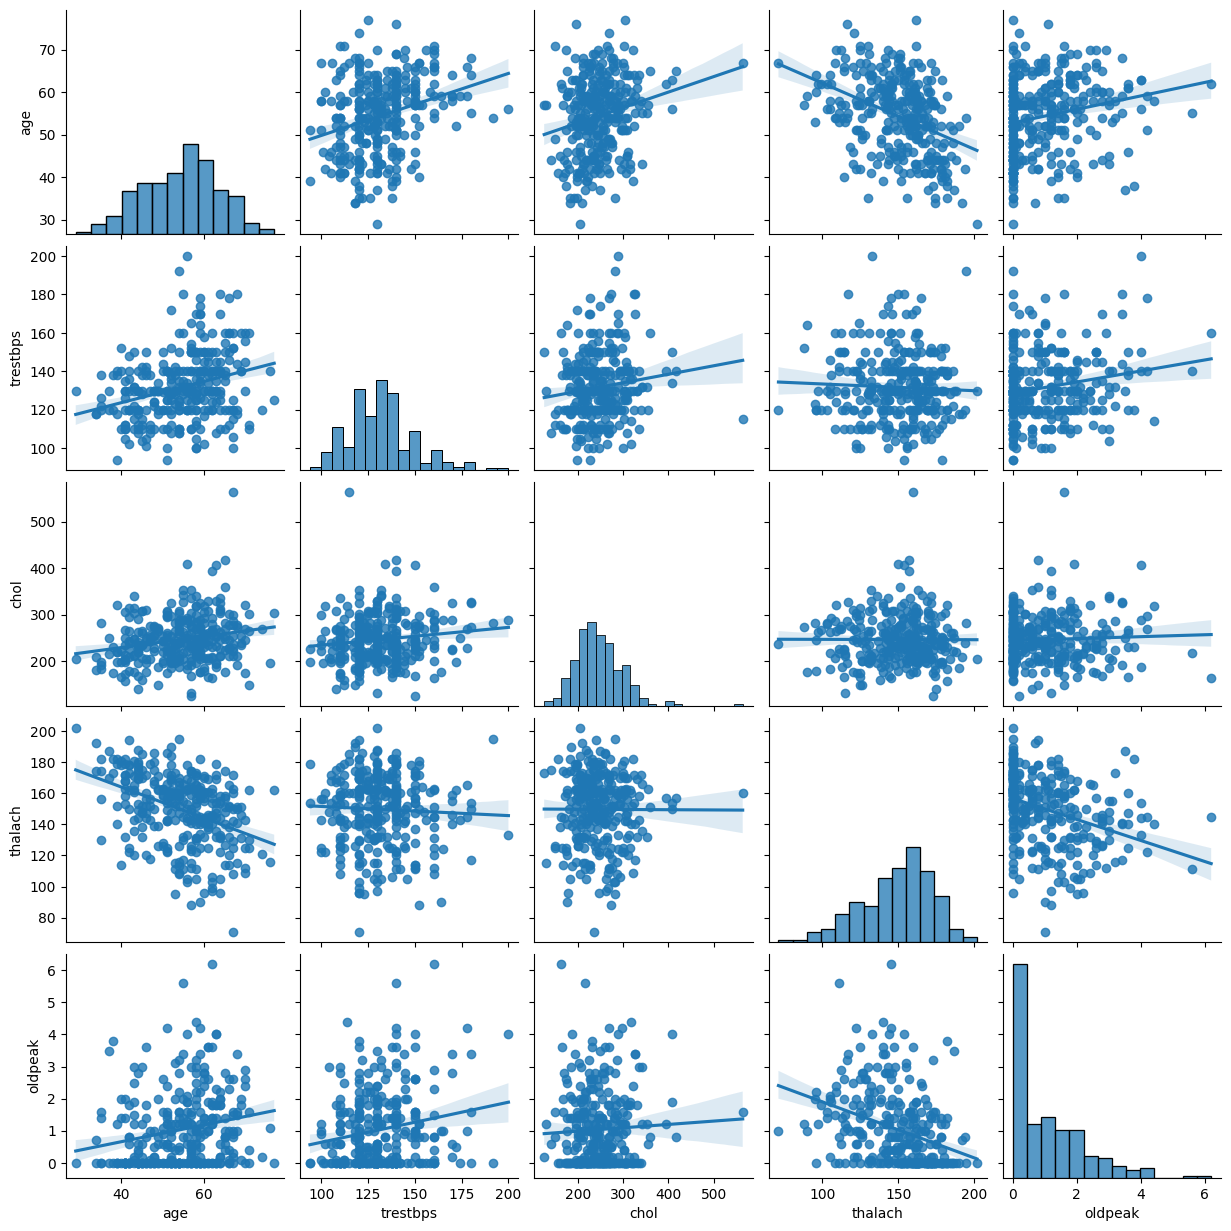

In [376]:
# pairwise plots of continuous data, looking for rough trends
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    cols2plot = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    sns.pairplot(X[cols2plot], kind = 'reg')
    plt.show()

In [263]:
#One hot encode the categorical variables for machine learning
X_encoded = pd.get_dummies(X, columns=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], prefix=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])



In [264]:
print(X_encoded.head())

   age  trestbps  chol  thalach  oldpeak  sex_0  sex_1   cp_1   cp_2   cp_3  \
0   63       145   233      150      2.3  False   True   True  False  False   
1   67       160   286      108      1.5  False   True  False  False  False   
2   67       120   229      129      2.6  False   True  False  False  False   
3   37       130   250      187      3.5  False   True  False  False   True   
4   41       130   204      172      1.4   True  False  False   True  False   

   ...  slope_1  slope_2  slope_3  ca_0.0  ca_1.0  ca_2.0  ca_3.0  thal_3.0  \
0  ...    False    False     True    True   False   False   False     False   
1  ...    False     True    False   False   False   False    True      True   
2  ...    False     True    False   False   False    True   False     False   
3  ...    False    False     True    True   False   False   False      True   
4  ...     True    False    False    True   False   False   False      True   

   thal_6.0  thal_7.0  
0      True     False  
1 

In [265]:
#Now I must normalize the continuous data
cols2zscore = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

X_norm1 = X_encoded.copy()

X_norm1[cols2zscore] = X_encoded[cols2zscore].apply(stats.zscore)



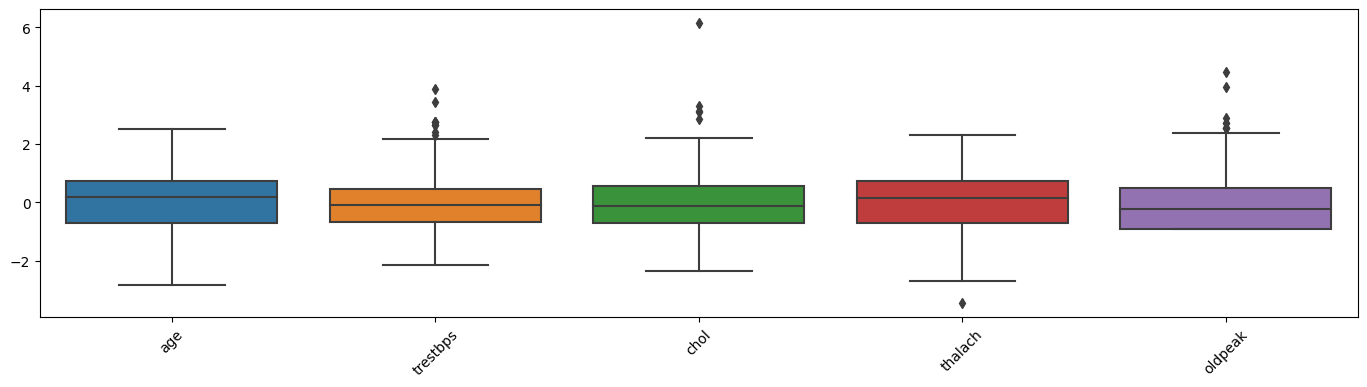

In [266]:
# check the plot 
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    fig,ax = plt.subplots(1,figsize=(17,4))
    ax = sns.boxplot(data=X_norm1[cols2zscore])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    plt.show()

In [267]:
#Remove the outlier visible at the top of the cholesterol boxplot
dropped_indices = X_norm1[X_norm1['chol'] > 5].index

X_norm = X_norm1[X_norm1['chol']<5] # drop an outlier
y_norm = y_norm1.drop(dropped_indices)

X_norm = X_norm.reset_index(drop = True)
y_norm = y_norm.reset_index(drop = True)

              
    

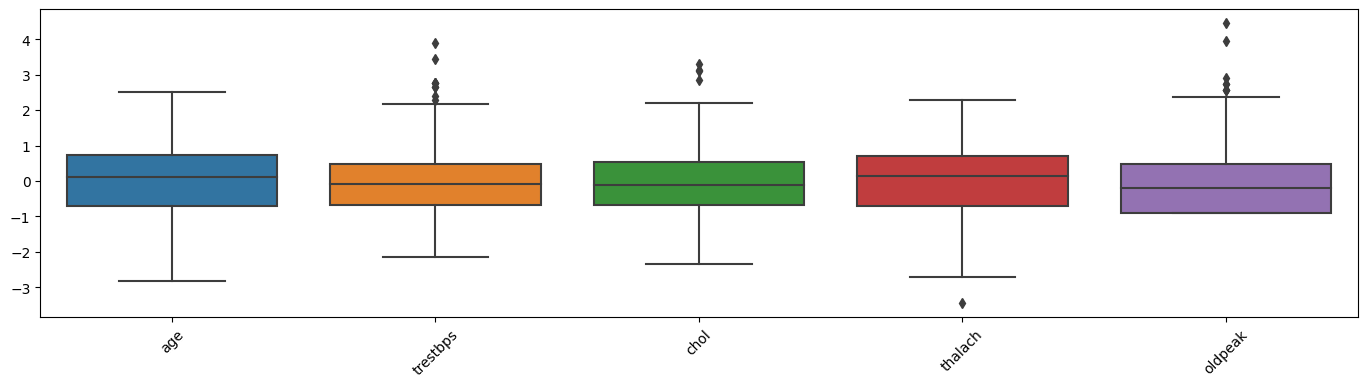

In [268]:
# check the plot again
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    fig,ax = plt.subplots(1,figsize=(17,4))
    ax = sns.boxplot(data=X_norm[cols2zscore])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    plt.show()

In [269]:
# Want to verify we have roughly equal amounts of data in each binary category
print(y_norm["num"].value_counts())

num
0    163
1    139
Name: count, dtype: int64


## Now that the data has been cleaned, time to reorganize into train/test loaders

In [381]:
# convert from pandas dataframe to tensor
X_norm_numpy = X_norm.astype(float).values  # Convert to a NumPy array
dataT = torch.tensor(X_norm_numpy)  # Create a PyTorch tensor
labels = torch.tensor( y_norm["num"].astype(float))
labels = labels[:,None] # transform to matrix



In [271]:


partitions = [.8,.1,.1]

# split the data (note the third input, and the TMP in the variable name)
train_data,testTMP_data, train_labels,testTMP_labels = \
                   train_test_split(dataT, labels, train_size=partitions[0])

# now split the TMP data
split = partitions[1] / np.sum(partitions[1:])
devset_data,test_data, devset_labels,test_labels = \
              train_test_split(testTMP_data, testTMP_labels, train_size=split)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)
devset_Dataset = TensorDataset(devset_data, devset_labels)

#convert into data loaders
batchsize    = 32
train_loader = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
devset_loader = DataLoader(devset_Dataset, batch_size = devset_Dataset.tensors[0].shape[0])

## Now for the Deep Learning

In [409]:
# Now I will create a class for the model
def createTheHeartNet():
    
    class HeartNet(nn.Module):
        def __init__(self):
            super().__init__()

            #parameters
            self.dr = .2 #This parameter controls the dropout rate
            
            #input layer
            self.input = nn.Linear(28,64)
            
            #hidden layer
            self.fc1 = nn.Linear(64,64)
            self.fc2 = nn.Linear(64,64)
    
            #output layer
            self.output = nn.Linear(64,1)
    
        # the forward pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.dropout(x,p=self.dr,training=self.training) #implement dropout between layers to prevent overfitting
            x = F.relu(self.fc1(x))
            x = F.dropout(x,p=self.dr,training=self.training)
            x = F.relu(self.fc2(x))
            x = F.dropout(x,p=self.dr,training=self.training)
            
            return self.output(x) 
            
    # create the model instance
    net = HeartNet()

    #Loss fun and Optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.RMSprop(net.parameters(),lr=.001, weight_decay=.05) #weight_decay refers to L2 regularization

    return net,lossfun,optimizer

In [410]:
#run some fake data to make sure it works properly
net,lossf,opt = createTheHeartNet()
print(net)

# input is ten samples
input = torch.rand(10,28)
net(input)

HeartNet(
  (input): Linear(in_features=28, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)


tensor([[0.0680],
        [0.0718],
        [0.0594],
        [0.0432],
        [0.0308],
        [0.0743],
        [0.0406],
        [0.0643],
        [0.0670],
        [0.0502]], grad_fn=<AddmmBackward0>)

In [411]:
# Now I will create a function that trains the model

def trainingFunction():
    
    numepochs = 200
    theBestModel = {'Accuracy':0, 'net':None}

    #Create a new model
    net,lossfun,optimizer = createTheHeartNet()

    #Initializing losses
    losses   = torch.zeros(numepochs)
    trainAcc = []
    devAcc  = []

    for epochi in range(numepochs):
        net.train()

        #loop over training batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

            #forward pass and calculate loss
            X=X.float()
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #append loss
            batchLoss.append(loss.item())

            #determine accuracy and add
            batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
            
        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # devset accuracy
        net.eval()
        X,y = next(iter(devset_loader)) # extract X,y from devset dataloader
        with torch.no_grad(): # deactivates autograd
            X=X.float()
            yHat = net(X)
        devAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )


            # Store this model if it's the best so far
        if devAcc[-1]>theBestModel['Accuracy']:
            theBestModel['Accuracy'] = devAcc[-1]
            theBestModel['net'] = copy.deepcopy( net.state_dict() )

    
        
    # function output
    return trainAcc,devAcc,losses,theBestModel 


In [422]:
trainAcc,devAcc,losses,theBestModel = trainingFunction() #Takes under 10 seconds usually
#This may occasionally perform badly depending on how the weights are initialized. Rerun this cell if performance is bad.

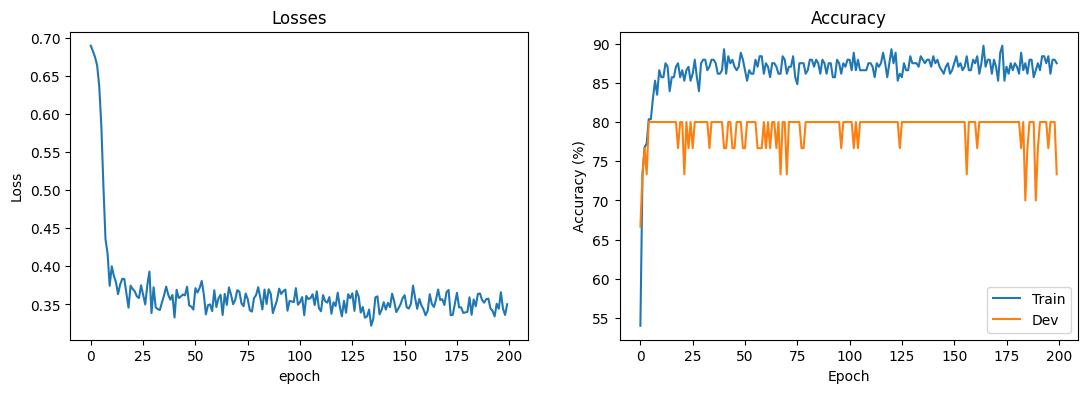

In [423]:
fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(devAcc,label='Dev')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

- With a dropout rate of .2 and an L2lambda of .05, our dev set usually gets around 80% accuracy.
- I want to see how accurate the model is for both labels--heart disease vs no heart disease


In [424]:
# Now I load the best model onto a new model so I can establish final predictions
bestnet = createTheHeartNet()[0] 
bestnet.load_state_dict(theBestModel['net']) #loading the weights and biases of our best model onto a new model
bestnet.eval() # We must turn on eval mode so drop out does not occur during eval

HeartNet(
  (input): Linear(in_features=28, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)

In [425]:
#Last pass through of network with train and dev data to establish final predictions
y_train = train_labels
X_dev,y_dev = next(iter(devset_loader))
yHat_train = bestnet(train_data.float())
yHat_train = (yHat_train>0).float() 
yHat_dev = bestnet(X_dev.float())
yHat_dev = (yHat_dev>0).float()


In [426]:
def getcategoryaccuracy(pred, actual): #takes predicted and actual values in the forms of tensors
    correct_1_count = 0
    correct_0_count = 0
    for i in range(len(pred)):
        if pred[i]==actual[i]:
            if pred[i]==1:
                correct_1_count+=1
            elif pred[i]==0:
                correct_0_count+=1
    perc_1_correct = (correct_1_count/torch.sum(actual==1))*100
    perc_0_correct = (correct_0_count/torch.sum(actual==0))*100

    return perc_0_correct, perc_1_correct #returns the percent of 0s and 1s the network guessed correctly 
    
    
                
        
    

80.91286420822144
80.0000011920929


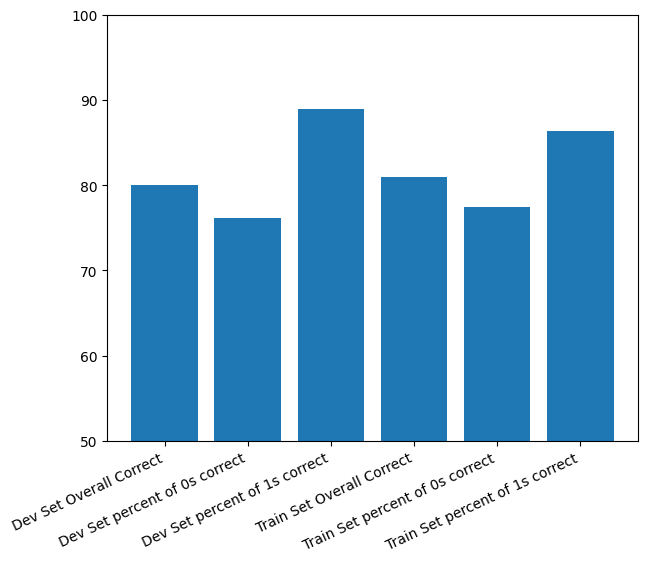

In [427]:
dev_perc_0_correct, dev_perc_1_correct = getcategoryaccuracy(y_dev, yHat_dev)
train_perc_0_correct, train_perc_1_correct = getcategoryaccuracy(y_train, yHat_train)
train_overall_acc = 100*torch.mean(((yHat_train>0) == y_train).float()).item()
dev_overall_acc = 100*torch.mean(((yHat_dev>0) == y_dev).float()).item()
print(train_overall_acc)
print(dev_overall_acc)


categories = ["Dev Set Overall Correct", "Dev Set percent of 0s correct", "Dev Set percent of 1s correct","Train Set Overall Correct", "Train Set percent of 0s correct", "Train Set percent of 1s correct"]
values = [dev_overall_acc, dev_perc_0_correct, dev_perc_1_correct,train_overall_acc,train_perc_0_correct,train_perc_1_correct]
              
plt.bar(categories, values)
plt.tight_layout()
plt.ylim(50,100)
plt.xticks(rotation = 25, ha = "right")
plt.show()

### Testing the network on the final test set

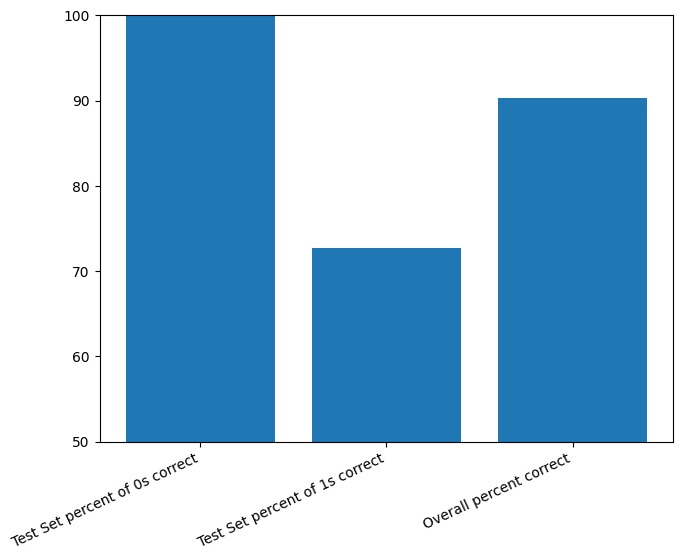

In [428]:
testset_pred = bestnet(test_data.float())
testset_pred = (testset_pred>0).float()
overall_acc = 100*torch.mean(((testset_pred>0) == test_labels).float()).item()

test_perc_0_correct, test_perc_1_correct = getcategoryaccuracy(testset_pred, test_labels)

categories1 = ["Test Set percent of 0s correct", "Test Set percent of 1s correct", "Overall percent correct"]
values1 = [test_perc_0_correct, test_perc_1_correct, overall_acc]
              
plt.bar(categories1, values1)
plt.tight_layout()
plt.ylim(50,100)
plt.xticks(rotation = 25, ha = "right")
plt.show()